In [1]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
from ipywidgets import interact
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.rcParams['figure.dpi'] = 200

In [2]:
file_headers = ["/media/user1/Data 2000/soft_robotics_experiments/training_data/round_1/module1_fullext1",
                "/media/user1/Data 2000/soft_robotics_experiments/training_data/round_1/module1_fullext2",
                "/media/user1/Data 2000/soft_robotics_experiments/training_data/round_1/module1_fullext3",
                "/media/user1/Data 2000/soft_robotics_experiments/training_data/round_1/module1_fullext4",
                "/media/user1/Data 2000/soft_robotics_experiments/training_data/round_1/module2_fullext1",
                "/media/user1/Data 2000/soft_robotics_experiments/training_data/round_1/module2_fullext2",
                "/media/user1/Data 2000/soft_robotics_experiments/training_data/round_1/module2_fullext3",
                "/media/user1/Data 2000/soft_robotics_experiments/training_data/round_1/module2_fullext4",
                "/media/user1/Data 2000/soft_robotics_experiments/training_data/round_1/s_curve1",
                "/media/user1/Data 2000/soft_robotics_experiments/training_data/round_1/s_curve2"]

CSV_SFX = ".csv"
MARKERS_SFX = "_markers"
POLY_SFX = "_poly"
M10Y = "M10Y"

In [3]:
data_list = []
marker_list = []
poly_list = []

TIME_STEPS = 128
SAMPLE_STEPS = 4

x_labels = ["M1-PL", "M1-PR", "M2-PL", "M2-PR"]
y_labels = ["a0", "a1", "a2", "a3", "a4", "a5", "d"]

INPUT_DIM = len(x_labels)
OUTPUT_DIM = len(y_labels)

def get_index_groups(df):
    return poly_df.groupby(poly_df.index.to_series().diff().ne(1).cumsum()).groups

def expand_time_steps(data, time_steps, sample_steps):
    entries = data.shape[0] - time_steps + 1
    rows = int(time_steps / sample_steps)
    cols = data.shape[1]
    new_arr = np.zeros((entries, rows, cols))
    for i in range(data.shape[0] - time_steps + 1):
        full_arr = data.iloc[i:i + time_steps].to_numpy()
        new_arr[i, :, :] = full_arr[sample_steps - 1::sample_steps]
    return new_arr

In [4]:
for header in file_headers:
    data_file = header + CSV_SFX
    marker_file = header + MARKERS_SFX + CSV_SFX
    poly_file = header + POLY_SFX + CSV_SFX
    
    data_df = pd.read_csv(data_file)
    marker_df = pd.read_csv(marker_file)
    poly_df = pd.read_csv(poly_file)
    
    # NOTE: Handle when the robot goes out of frame.
    zero_indices = list(marker_df[marker_df[M10Y] == 0].index)
    
    data_df = data_df.drop(data_df.index[zero_indices])
    marker_df = marker_df.drop(marker_df.index[zero_indices])
    poly_df = poly_df.drop(poly_df.index[zero_indices])
    
    data_list.append(data_df)
    marker_list.append(marker_df)
    poly_list.append(poly_df)

# Multiple Paths Examples

In [5]:
file_idx = 9
data_df = data_list[file_idx]
marker_df = marker_list[file_idx]
poly_df = poly_list[file_idx]

poly_sample = poly_df.sample(frac=0.05)

a_coeff = np.flip(poly_sample.iloc[0].to_numpy())



# Same Pressures Different Shapes

In [6]:
DIFF = 0.2 # acceptable average difference in pressure kPa
PROX = 100

similar_pressures = {}
used_points = []

def inspect(d1, d2):
    diff = np.abs(d1 - d2)
    ave_diff = np.average(diff)
    if ave_diff < DIFF:
        return True
    else:
        return False

for if1, df1 in enumerate(data_list):
    for ip1, dp1 in enumerate(df1[x_labels].to_numpy()):
        # go through every other point.
        if (if1, ip1) not in used_points:
            for if2, df2 in enumerate(data_list):
                for ip2, dp2 in enumerate(df2[x_labels].to_numpy()):
                    similar_flag = False
                    if if1 is not if2:
                        similar_flag = inspect(dp1, dp2)
                    else: 
                        prox = ip1 - ip2
                        if prox > PROX:
                            similar_flag = inspect(dp1, dp2)
                    if similar_flag:
                        used_points.append(key2)
                        key1 = (if1, ip1)
                        key2 = (if2, ip2)
                        if key1 in similar_pressures:
                            similar_pressures[key1].append(key2)
                        else:
                            similar_pressures[key1] = []
print(len(similar_pressures))

NameError: name 'key2' is not defined

In [7]:
def similar_pressures_display(key=(1,len(similar_pressures),1)):
    start_point = list(similar_pressures.keys())[key]
    sims = [start_point]
    sims += similar_pressures[start_point]
    print(start_point)
    print(sims)
    for dp in sims:
        poly = poly_list[dp[0]].iloc[dp[1]]
        a = np.flip(poly[:-1])
        d = poly[-1]
        poly_fit = np.poly1d(a)
        y = np.linspace(0, d)
        x = poly_fit(y)
        plt.plot(x,y)
    plt.xlim([-20,20])
    plt.ylim([-1,39])
    plt.show()
interact(similar_pressures_display)

ValueError: value must be between min and max (min=1, value=0, max=0)

In [14]:
similarities = [(0, 428), (1, 410), (1, 453), (3, 517)]
similarities = [(0, 427), (1, 453), (3, 480), (3, 516)]
similarities = [(0, 384), (1, 360), (2, 429), (3, 451)]#, (8, 804)]

def color_progression(idx=(0,len(similarities)-1,1)):
    end = similarities[idx]
    steps_back = 256
    file_idx = end[0]
    point_idx = end[1]
    viridis = cm.get_cmap('viridis', steps_back)
    progression = poly_list[file_idx].iloc[point_idx - steps_back:point_idx,:]
    for p in range(len(progression)):
        poly = progression.iloc[p]
        a = np.flip(poly[:-1])
        d = poly[-1]
        poly_fit = np.poly1d(a)
        y = np.linspace(0, d)
        x = poly_fit(y)
        plt.plot(x,y, color=viridis(p))
    plt.xlim([-12,12])
    plt.ylim([-1,33])
    plt.grid()
    plt.show()
interact(color_progression)

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.color_progression(idx=(0, 4, 1))>

Curr Time: 172.087, Prev Time: 50.675, Diff Time: 121.41199999999999
Curr Time: 182.989, Prev Time: 61.314, Diff Time: 121.67500000000001
Curr Time: 213.345, Prev Time: 91.456, Diff Time: 121.889
Curr Time: 202.533, Prev Time: 82.223, Diff Time: 120.30999999999999


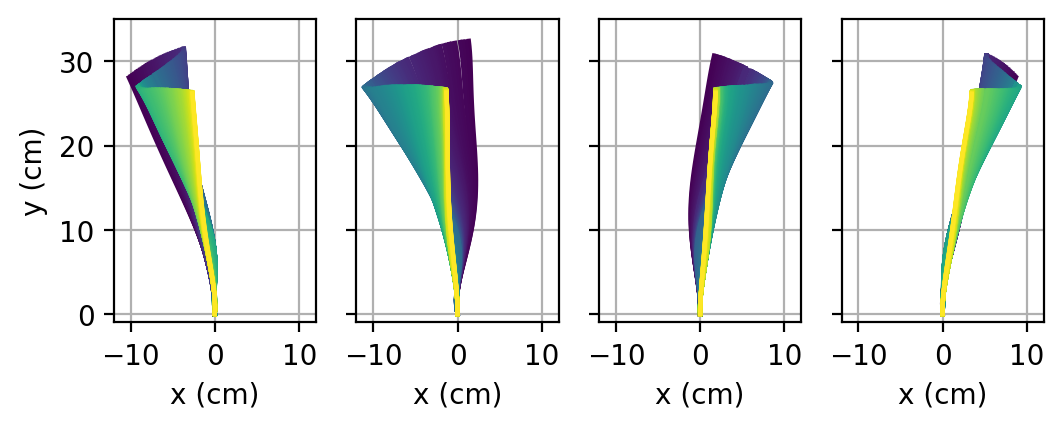

In [47]:
similarities = [(0, 384), (3, 451), (2, 429), (1, 360)]
fig, axs = plt.subplots(1,4)
for idx, ax in enumerate(axs):
    end = similarities[idx]
    steps_back = 256
    curr_time = data_list[file_idx].loc[point_idx, "TIME"]
    prev_time = data_list[file_idx].loc[point_idx - steps_back, "TIME"]
    diff_time = curr_time - prev_time
    print("Curr Time: " + str(curr_time) + ", Prev Time: " + str(prev_time) + ", Diff Time: " + str(diff_time))
    file_idx = end[0]
    point_idx = end[1]
    viridis = cm.get_cmap('viridis', steps_back)
    progression = poly_list[file_idx].iloc[point_idx - steps_back:point_idx,:]
    for p in range(len(progression)):
        poly = progression.iloc[p]
        a = np.flip(poly[:-1])
        d = poly[-1]
        poly_fit = np.poly1d(a)
        y = np.linspace(0, d)
        x = poly_fit(y)
        ax.plot(x,y, color=viridis(p))
    ax.set(aspect='equal')
    ax.set_xlim([-12,12])
    ax.set_ylim([-1,35])
    ax.set(xlabel='x (cm)', ylabel='y (cm)')
    ax.grid()
    ax.label_outer()

plt.show()

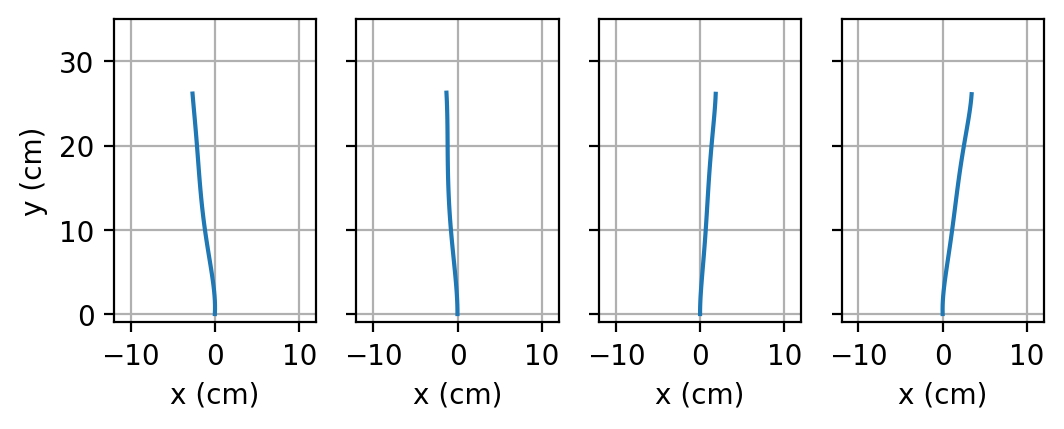

<Figure size 1200x800 with 0 Axes>

In [35]:
similarities = [(0, 384), (3, 451), (2, 429), (1, 360)]
fig, axs = plt.subplots(1,4)
for idx, ax in enumerate(axs):
    point = similarities[idx]
    file_idx = point[0]
    point_idx = point[1]
    poly = poly_list[file_idx].iloc[point_idx, :]
    a = np.flip(poly[:-1])
    d = poly[-1]
    poly_fit = np.poly1d(a)
    y = np.linspace(0, d)
    x = poly_fit(y)
    ax.plot(x,y)
    ax.set(aspect='equal')
    ax.set_xlim([-12,12])
    ax.set_ylim([-1,35])
    ax.set(xlabel='x (cm)', ylabel='y (cm)')
    ax.grid()
    ax.label_outer()
    
plt.show()

In [42]:
similarities = [(0, 384), (3, 451), (2, 429), (1, 360)]
for s in similarities:
    file_idx = s[0]
    point_idx = s[1]
    
    print(data_list[file_idx].loc[point_idx, x_labels])

maxi = 0
max_files = 0
for s in similarities:
    for d in similarities:
        sp = data_list[s[0]].loc[s[1], x_labels]
        dp = data_list[d[0]].loc[d[1], x_labels]
        difference = np.abs(sp-dp)
        for m in difference:
            if m > maxi:
                maxi = m
                max_files = s,d
print(maxi)
print(max_files)

M1-PL    101.047
M1-PR    100.722
M2-PL    100.697
M2-PR    100.459
Name: 384, dtype: float64
M1-PL    100.809
M1-PR    100.734
M2-PL    100.640
M2-PR    100.528
Name: 451, dtype: float64
M1-PL    101.203
M1-PR    100.540
M2-PL    100.672
M2-PR    100.428
Name: 429, dtype: float64
M1-PL    101.159
M1-PR    100.609
M2-PL    100.584
M2-PR    100.440
Name: 360, dtype: float64
0.39400000000000546
((3, 451), (2, 429))


In [15]:
similarities = [(0, 384), (1, 360), (2, 429), (3, 451), (8, 804)]

def color_progression(idx=(0,len(similarities)-1,1)):
    point = similarities[idx]
    file_idx = point[0]
    point_idx = point[1]
    poly = poly_list[file_idx].iloc[point_idx, :]
    a = np.flip(poly[:-1])
    d = poly[-1]
    poly_fit = np.poly1d(a)
    y = np.linspace(0, d)
    x = poly_fit(y)
    plt.plot(x,y)
    plt.xlim([-12,12])
    plt.ylim([-1,33])
    plt.grid()
    plt.show()
interact(color_progression)

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.color_progression(idx=(0, 4, 1))>

# Training Graphs of DNN and RNN

Text(0, 0.5, 'Mean Squared Error')

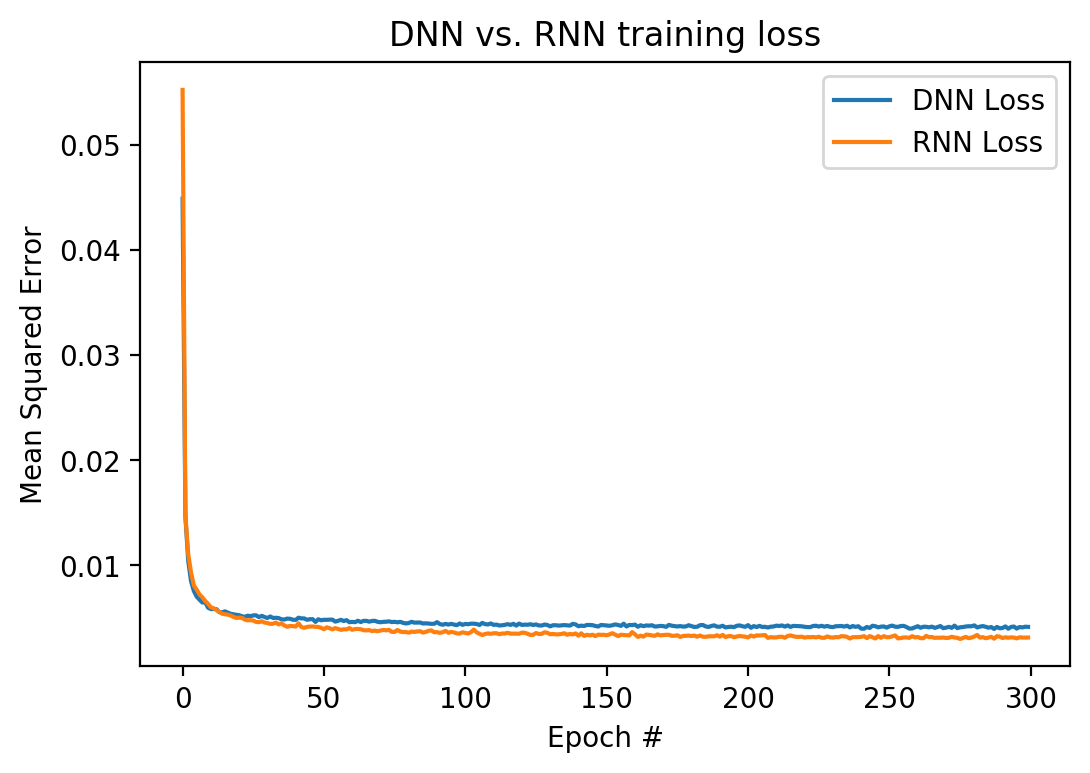

In [55]:
dnn_loss = pickle.load(open("objects/dnn_loss.p", "rb"))
rnn_loss = pickle.load(open("objects/rnn_loss.p", "rb"))
plt.plot(dnn_loss, label="DNN Loss")
plt.plot(rnn_loss, label="RNN Loss")
plt.legend()
plt.title("DNN vs. RNN training loss")
plt.xlabel("Epoch #")
plt.ylabel("Mean Squared Error")